In [0]:
%matplotlib inline

# Workflow report

##    1. Glossary
**a) GIS**: GIS means Geographic Information System, which mainly includes the following characteristics like (1)public geographic positioning foundation; (2) ability to collect, manage, analyze and output a variety of geospatial information; (3)system driven by analytical model, with strong spatial comprehensive analysis and dynamic prediction capabilities, and can produce high-level geographic information; (4)for the purpose of geographic research and geographic decision-making, it is a human-computer interactive spatial decision support system.

**b) QGIS**: QGIS is a user-friendly, cross-platform, open-source desktop geographic information system based on Qt and developed using C ++.

**c) GEOTIFF**: GeoTIFF based on the TIFF defines a number of the GeoTag (geographic label), to store the various coordinate systems, reference ellipsoid, projection information, so that the number of image data and geographic The data is stored in the same image file .

**d) Attention model**: A resource allocation model. At a certain moment, its attention is always focused on one focal part of the picture, and ignores other parts.

![exp for attention model 1](https://drive.google.com/uc?id=12wrHjYcDKUzzzFEY4Fg4QScGX4WKocuZ)












## 2. Workflow

We need to segment the large GEOTIFF picture and send each part of the small picture to the Building Detection model for drawing out buildings, then the detected building group is sent to the Damage level Detection model which can find out how serious the damage is. Finally, we need to union the cut images as 2 GEOTIFF graphs of the building detection result and the damage level detection result. The implementation method is as follows:

### a) Image segmentation

At this stage I plan to use python's gdal library to cut the huge image. Firstly we read in a set of GEOTIFF pictures (pre and post pictures) as a set of array which save various information, then cut original pictures into 1024 * 1024 pixels small pictures and save them as png format. In order to make sure the house is still complete from cutting, we investigate pixel by pixel at the cutting edge. If the adjacent pixel of the cutting border is also a building and box is not on the far right or top, we move cutting box to the left or down until the building is completely contained in the submap.

In [0]:
#import GeoTIFF package
import gdal
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

In [0]:
#read the GeoTIFF file
def read_img(dataset): 
  im_width = dataset.RasterXSize    
  im_height = dataset.RasterYSize
  im_geotrans = dataset.GetGeoTransform() #affine matrix 
  im_proj = dataset.GetProjection() #Map projection information 
  im_data = dataset.ReadAsArray(0,0,im_width,im_height) 
  del dataset 
  return im_proj,im_geotrans,im_data

In [0]:
#cut image
def cut_image(data):
  global count_subimage
  channel, width, height = data.shape
  for i in range(width//256):
    for j in range(height//256):
      cur_image = data[:,i*256:(i+1)*256,j*256:(j+1)*256]
      array = cur_image.swapaxes(1,0)
      array = array.swapaxes(2,1)
      image = Image.fromarray(np.uint8(array)) 
      image.save('/home/molan/Desktop/sub_png/' + str(count_subimage).zfill(5) + '.png')
      #save cutted images as png format
      
      count_subimage += 1
  # TO DO: if adjacent pixel is building, move cutting box until cuttable (need GeoTIFF files which include building tags)



In [0]:
# Do a test:
dataset=gdal.Open('/home/molan/Downloads/Tsunami_groundtruth_data/bi-temporal/reg_t01_bef.tif')
count_subimage = 0
proj,geotrans,data = read_img(dataset)
cut_image(data)
print(data.shape)





(3, 1860, 2400)


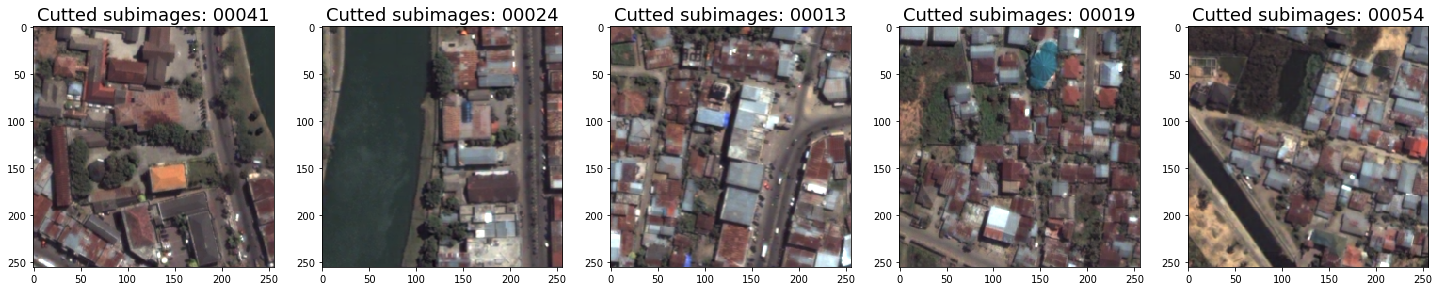

In [0]:
#TO DO show some sub-images 
import random
figure, ax = plt.subplots(1,5, figsize=(25,16))
for i in range(5):
  exp_n = random.randint(0,count_subimage)
  img = mpimg.imread('/home/molan/Desktop/sub_png/' + str(exp_n).zfill(5) + '.png')
  ax[i].imshow(img)
  ax[i].set_title('Cutted subimages: '+str(exp_n).zfill(5), fontsize=18) 
plt.show()

###        b) Building detection model


Mask R-CNN is a simple, flexible, and general framework for object instance segmentation. It can efficiently detect objects in an image while simultaneously generating a high-quality segmentation mask for each instance. Mask R-CNN extends Faster R-CNN by adding a branch for predicting an object mask in parallel with the existing branch for bounding box recognition.

![Mask_RCNN](https://drive.google.com/uc?id=1hAJXYFipxZigH2cLpeKwOJcWBgj2MT_T)

Here we use the mask RCNN model for building detection. We will compare the trained mask RCNN model with the Microsoft building footprints detection model. We plan to use completely new sample pictures for detection and compare experimental results by calculating values such as accuracy and mAP.

In [0]:
# import necessary packages
import os
import sys
import math
import re
import time
import matplotlib
import json 
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("/Desktop/xview2/code/mask_rcnn/Mask_RCNN-master/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log




/home/molan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/molan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/molan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/molan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [0]:
# Configurations

class xview2Config(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "xview2"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = xview2Config()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
# Dataset

class xview2Dataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    def load_xview2(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        dataset='/home/molan/Desktop/xview2/train/images/'
        dataset_dir='/home/molan/Desktop/xview2/train/images/'
        self.add_class("xview2", 1, "building")
        k = 0
        # Train or validation dataset?
        dataset_dir = os.path.join(dataset_dir, 'images/')
        json_dir = os.path.join(dataset, 'labels/')
        if subset =='train' : 
            file_list=open('/home/molan/Desktop/xview2/train/train_json.txt','r')
            print('train')
        else:
            file_list=open('/home/molan/Desktop/xview2/train/val_json.txt','r')
            print('val')

        # Load annotations
        for file in file_list:
            a = file.replace('json\n','json')
            if 'pre' in file :
                polygons = []
                label = []
                file1=json.load( open(json_dir+a, 'r'))
                for i in range(len(file1['features']['xy'])):
                    wkt=file1['features']['xy'][i]['wkt'][10:-2].replace(",",'')
                    wkt_list=wkt.split(" ")
                    x=[]
                    y=[]
                    for value in range(len(wkt_list)):
                        if value % 2 == 0:
                            x.append(float(wkt_list[value]) )
                        else:
                           y.append(float(wkt_list[value]) )
                    polygons_1 = [x,y]
                    polygons.append(polygons_1)
                    label_1 = 'building'
                    label.append(label_1)
                label_dict = {"building":1}
                label_id = [label_dict[a] for a in label]

                # load_mask() needs the image size to convert polygons to masks.
                # Unfortunately, VIA doesn't include it in JSON, so we must read
                # the image. This is only managable since the dataset is tiny.
                img_dir = dataset_dir
                image_path = os.path.join(img_dir, file1['metadata']['img_name'])
                image = skimage.io.imread(image_path)
                height=1024
                width = 1024

                self.add_image(
                    "xview2",
                    image_id=k,  # use file name as a unique image id
                    path=image_path,
                    class_id = label_id,
                    width=width, height=height,
                    polygons=polygons)
                k += 1
        print(k)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "xview2":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        label_id = image_info["class_id"]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        class_ids = np.array(label_id, dtype=np.int32)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p[1], p[0])
            rr = [min(i,1023) for i in rr]
            rr = [max(0,i) for i in rr]
            cc = [min(i,1023) for i in cc]
            cc = [max(0,i) for i in cc]
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return (mask.astype(np.bool), class_ids)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "xview2":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [0]:
# define test ways and build test dataset

def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    white = np.ones((1024,1024,3)) 
    black = np.zeros((1024,1024,3))
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, white, black)
    else:
        splash = black
    return splash

In [0]:
# load trained building detection models and sub-images.

# Validation dataset
dataset_val = xview2Dataset()
dataset_val.load_xview2('dataset', "val")
dataset_val.prepare()

class InferenceConfig(xview2Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()
config.display()

# Create model and load weights
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir='args.logs')
# Load weights
weights_path = '/home/molan/Desktop/xview2/code/mask_rcnn/Mask_RCNN-master/mask_rcnn_xview2.h5'
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)


val
571

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE

original_image           shape: (1024, 1024, 3)       min:    7.00000  max:  242.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (11,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (11, 4)               min:    2.00000  max:  387.00000  int32
gt_mask                  shape: (1024, 1024, 11)      min:    0.00000  max:    1.00000  bool


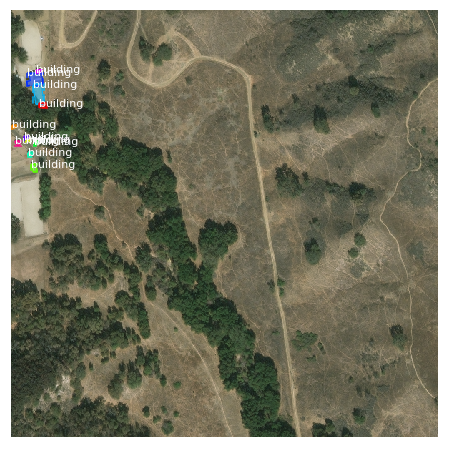

In [0]:
# show a testing result on a random image
image_id = np.random.choice(dataset_val.image_ids, 1)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(dataset_val, config, 
                           image_id.item(), use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names,figsize=(8, 8))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    7.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -114.70000  max:  136.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


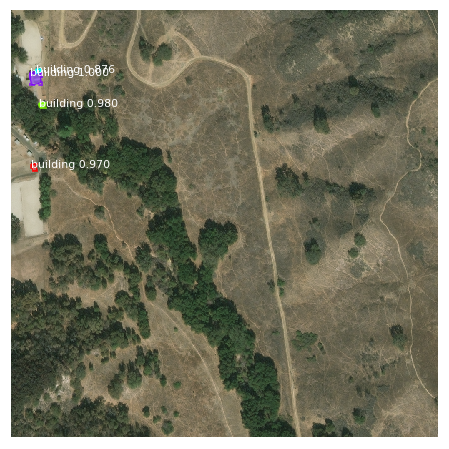

In [0]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

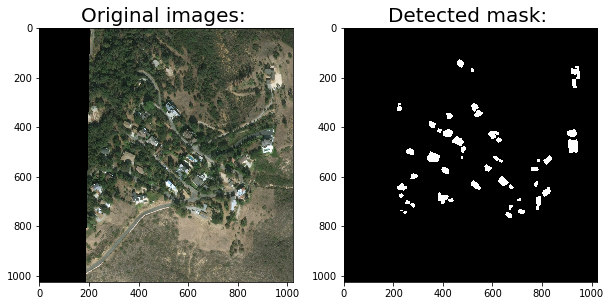

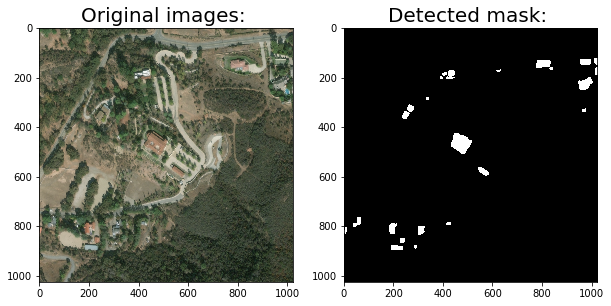

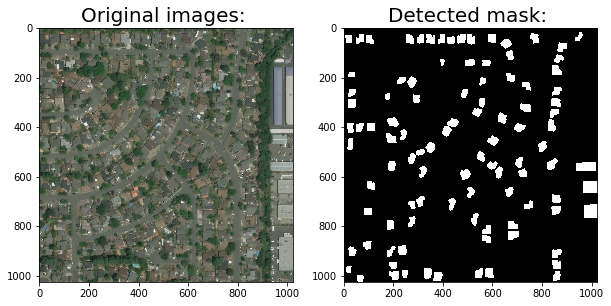

In [0]:
# do pretection 

image_ids = np.random.choice(dataset_val.image_ids, 3)
APs = []
Precisions = []
Recalls = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP) 
    Precisions.append(np.mean(precisions))
    Recalls.append(np.mean(recalls))
    splash = color_splash(image, r['masks'])
    figure, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].set_title('Original images: ', fontsize=20) 
    ax[1].set_title('Detected mask: ', fontsize=20) 
    ax[0].imshow(image)
    ax[1].imshow(splash)
    plt.show()


In [0]:
# show some detection results

print("mAP: ", np.mean(APs))
print("mean precision: ", np.mean(Precisions))
print("mean recall: ", np.mean(Recalls))

mAP:  0.5030018719126635
mean precision:  0.8474608522050673
mean recall:  0.35207547455659177





###        c) Damage detection model
After detecting the building in the pre image, a pair of single building from pre and post images is cut out and sent to the Damage level Detection model. Here we built a triplet network model. Base model is pre-trained ResNet-50 model, and the building is combined of a 224 * 224 * 6 tensor which will be used to get feature embeddings.

#### Triplet network Architecture
Triplet damage detection network (TDDN) uses 3 CNN network which share weights with each other. The first channel is author image. The second channel is positive images which is same with the author image. The last channel is negative images.

![triplet net structure](https://drive.google.com/uc?id=15FgcutzUR5zh_qNAiita27ROoWwgor9q)

What we want is that we hope the similarity of author image and positive image can as high as possible while the similarity of author image and negative image can as low as possible.

We choose the loss function as the formula below:

![alt text](https://drive.google.com/uc?id=1QkN9urhHiXqIixWYKl8KUtN4Wp9zhiXJ)



#### Training structure
![training structure](https://drive.google.com/uc?id=1J3Pbsd20z6N4ge_TQG6SHuG6FRk14Wdk)

#### Testing structure
![testing structure](https://drive.google.com/uc?id=1i9BAQoFpYrxocH0duL1-iUCo0K4p79Rm)

In [0]:
# import some necessary packages

from os import listdir
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable 
import torch.cuda
import torchvision.transforms as transforms
import skimage.io
import torch.optim as optim
import tensorflow as tf


In [0]:
img_to_tensor = transforms.ToTensor()

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

In [0]:
# define loss function

def euclidean_dist(x, y, z):
    m = x.size(0)
    n = y.size(0)
    o = z.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    zz = torch.pow(z, 2).sum(1, keepdim=True).expand(o, m).t()
    dist1 = xx + yy
    dist1.addmm_(1, -2, x, y.t())
    dist1 = dist1.clamp(min=1e-12).sqrt()  # for numerical stability
    dist2 = xx + zz
    dist2.addmm_(1, -2, x, z.t())
    dist2 = dist2.clamp(min=1e-12).sqrt()  # for numerical stability
    ans = torch.mean(dist1) + torch.mean(dist2)
    d0 = torch.mean(dist2) / ans
    d1 = torch.mean(dist1) / ans
    loss= d1-d0+1
    loss = loss.sqrt()
    return loss

In [0]:
# damage level testing function

def test_loss_fun(model,pre,post,labels):
  # define the criterion
  # define an SGD optimizer with a lr = 0.001
    optimizer = optim.SGD(model.parameters(), lr=0.0001)
    model.eval()
    accuracy = 0
    test_loss_f = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        test_losss = []
        for k in range(4):
            pre_p = Image.open('/home/molan/Desktop/xview2/class_exp/'+str(k)+'_pre.png').convert('RGB')
            post_p = Image.open('/home/molan/Desktop/xview2/class_exp/'+str(k)+'_post.png').convert('RGB')
            if k < 2:
                exp_pre = Image.open('/home/molan/Desktop/xview2/class_exp/3_pre.png').convert('RGB')
                exp_post = Image.open('/home/molan/Desktop/xview2/class_exp/3_post.png').convert('RGB')
            else:
                exp_pre = Image.open('/home/molan/Desktop/xview2/class_exp/0_pre.png').convert('RGB')
                exp_post = Image.open('/home/molan/Desktop/xview2/class_exp/0_post.png').convert('RGB')
            pre_p = transform(pre_p)
            post_p = transform(post_p)
            exp_pre = transform(exp_pre)
            exp_post = transform(exp_post)
            n = np.zeros((1,6,224,224))
            a = np.zeros((1,6,224,224))
            p = np.zeros((1,6,224,224))
            #conbine pre and post in 6 channels
            for j in range(1):
                a[:,:3,:,:] = pre
                a[:,3:,:,:] = post
                p[:,:3,:,:] = pre_p
                p[:,3:,:,:] = post_p
                n[:,:3,:,:] = exp_pre
                n[:,3:,:,:] = exp_post
            # Forward pass, then backward pass, then update weights
            p = torch.Tensor(p).cuda()
            a = torch.Tensor(a).cuda()
            n = torch.Tensor(n).cuda()
            outputs_p = model(Variable(p))
            outputs_n = model(Variable(n))
            outputs_a = model(Variable(a))
            outputs_a_npy = outputs_a.reshape((1,100352))
            outputs_p_npy = outputs_p.reshape((1,100352))
            outputs_n_npy = outputs_n.reshape((1,100352))
            loss = euclidean_dist(outputs_a_npy,outputs_p_npy,outputs_n_npy)
            loss = loss.cpu()
            test_losss.append(loss.item())
        ans = test_losss.index(min(test_losss))
        test_loss_f += min(test_losss)
        if ans == labels :
            accuracy += 1  
            
    return test_loss_f, accuracy,ans

In [0]:
# do some actual test based on xview2 database
feature_model=torch.load('/home/molan/Desktop/xview2/class_model_triple_new.h5')
fp = open('/home/molan/Desktop/xview2/train/images/test_dataset.txt','r')
words = []
dataset_test_image_ids = []
i = 0
for line in fp:
    line = line.rstrip()
    words.append(line)
    dataset_test_image_ids.append(i)
    i += 1
    
image_ids = np.random.choice(dataset_test_image_ids, 50)
image_ids


array([ 3142, 12720, 19952,  8115, 26698, 35824, 15075, 34517, 17042,
       36943, 33183, 12815,  1750, 43237, 20855, 23130, 21993, 22240,
       46084, 17687, 34305, 13600, 16234, 31093, 49036, 48805, 46567,
       32556, 43014, 24771, 43412, 41995, 42117, 14628, 14914, 41072,
       48695, 41805, 21474, 22538, 19353, 33357,  2448, 35431,   893,
       14490, 35686, 38874, 18652, 41049])

In [0]:
loss = 0
accrucy = 0
for ids in image_ids:
    imgs = words[ids].split()
    pre_image_path = imgs[0]
    post_image_path = imgs[1]
    labels = int(imgs[2])
    pre_image = Image.open(pre_image_path).convert('RGB')
    post_image = Image.open(post_image_path).convert('RGB')
    pre_imag = transform(pre_image)
    post_imag = transform(post_image)
    loss_1, acc_1, ans_1 = test_loss_fun(feature_model,pre_imag,post_imag,labels)
    loss += loss_1
    accrucy += acc_1

In [0]:
# Print out the testing loss and accrucy

print("Test Loss: {:.3f}.. ".format(loss/50),
      "Test Accuracy: {:.3f}".format(accrucy/50))

Test Loss: 0.880..  Test Accuracy: 0.740


###        d) Picture union
Through the previous building detection and damage level detection, we generated a corresponding mask for each sub-picture. At this time, we need to merge the pixel information (whether it is a building and its disaster level) of the sub-picture into a new GeoTIFF file with all of the original GEOTIFF information.

In [0]:
def write_img(filename,im_proj,im_geotrans,im_data):
        #type of data in gdal
        #gdal.GDT_Byte, 
        #gdal .GDT_UInt16, gdal.GDT_Int16, gdal.GDT_UInt32, gdal.GDT_Int32,
        #gdal.GDT_Float32, gdal.GDT_Float64
 
        if 'int8' in im_data.dtype.name:
            datatype = gdal.GDT_Byte
        elif 'int16' in im_data.dtype.name:
            datatype = gdal.GDT_UInt16
        else:
            datatype = gdal.GDT_Float32
 
        if len(im_data.shape) == 3:
            im_bands, im_height, im_width = im_data.shape
        else:
            im_bands, (im_width, im_height) = 1,im_data.shape 
 
        driver = gdal.GetDriverByName("GTiff")            
        dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
        dataset.SetGeoTransform(im_geotrans)              
        dataset.SetProjection(im_proj)                   
        if im_bands == 1:
            dataset.GetRasterBand(1).WriteArray(im_data)  
        else:
            for i in range(im_bands):
                dataset.GetRasterBand(i+1).WriteArray(im_data[i])
                print(im_data[i].shape)
        del dataset


In [0]:

fp = listdir('/home/molan/Desktop/sub_png/')
fp.sort()
t_data = np.zeros((1860,2400,3))
k = 0
for i in range(1860//256):
    for j in range(2400//256):
        image = Image.open('/home/molan/Desktop/sub_png/'+fp[k]).convert('RGB')
        img_array = np.asarray(image)
        if (i+1)*256<1860 and (j+1)*256 <2400:
            t_data[i*256:(i+1)*256,j*256:(j+1)*256,:] = img_array
        elif (i+1)*256>=1860 and (j+1)*256 <2400:
            t_data[i*256:1860,j*256:(j+1)*256,:] = img_array[:(i+1)*256-1860,:,:]
        elif (i+1)*256<1860 and (j+1)*256 >=2400:
            t_data[i*256:1860,j*256:(j+1)*256,:] = img_array[:(i+1)*256-1860,:(j+1)*256-2400,:]
        elif (i+1)*256>=1860 and (j+1)*256 >=2400:
            t_data[i*256:1860,j*256:(j+1)*256,:] = img_array[:(i+1)*256-1860,:(j+1)*256-2400,:]
        k += 1
image = Image.fromarray(np.uint8(t_data))
image.show()
t_data = t_data.swapaxes(2,1)
t_data = t_data.swapaxes(1,0)
t_data.shape

(3, 1860, 2400)

In [0]:
union_pic = '/home/molan/Desktop/new_pic.tif'
write_img(union_pic,proj,geotrans,t_data)

(1860, 2400)
(1860, 2400)
(1860, 2400)


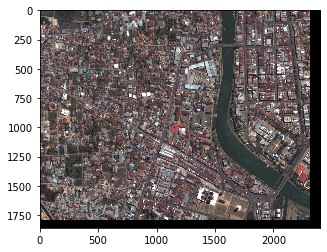

In [0]:
dataset=gdal.Open('/home/molan/Desktop/new_pic.tif')
proj,geotrans,data = read_img(dataset)
data = data.swapaxes(0,1)
data = data.swapaxes(2,1)
image = Image.fromarray(np.uint8(data))
plt.imshow(image)

### e) Actual whole picture test.

In the whole project. What we want to achieve is that user input a pair of GeoTIFF images which includes a pre-event and a post-event images. Then the model run step by step. Finally, model can give user 2 GeoTIFF files. One of it includes building labels and other original information. The other shows buildings' damage level with geographic information.

Here is the model's structure.

![base line](https://drive.google.com/uc?id=11NHAp6czIlvyKixNJj6nNiyl0VWQ0kFG)



This is a demo which used xview2 data to achieve.

In [0]:
# Damage Level Detection Model

def damage_level_test(image,x1,y1,x2,y2):
    pre_image_path =  image
    post_image_path = pre_image_path.replace('_pre_','_post_')
    pre_image = Image.open(pre_image_path).convert('RGB')
    post_image = Image.open(post_image_path).convert('RGB')
    pre_imag = pre_image.crop((x1,y1,x2,y2))
    pre = transform(pre_imag)
    post_imag = post_image.crop((x1,y1,x2,y2))
    post = transform(post_imag)
    model = torch.load('/home/molan/Desktop/xview2/class_model_triple_new.h5')
    # define the criterion
  # define an SGD optimizer with a lr = 0.001
    optimizer = optim.SGD(model.parameters(), lr=0.0001)
    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        test_losss = []
        for k in range(4):
            pre_p = Image.open('/home/molan/Desktop/xview2/class_exp/'+str(k)+'_pre.png').convert('RGB')
            post_p = Image.open('/home/molan/Desktop/xview2/class_exp/'+str(k)+'_post.png').convert('RGB')
            if k < 2:
                exp_pre = Image.open('/home/molan/Desktop/xview2/class_exp/3_pre.png').convert('RGB')
                exp_post = Image.open('/home/molan/Desktop/xview2/class_exp/3_post.png').convert('RGB')
            else:
                exp_pre = Image.open('/home/molan/Desktop/xview2/class_exp/0_pre.png').convert('RGB')
                exp_post = Image.open('/home/molan/Desktop/xview2/class_exp/0_post.png').convert('RGB')
            pre_p = transform(pre_p)
            post_p = transform(post_p)
            exp_pre = transform(exp_pre)
            exp_post = transform(exp_post)
            n = np.zeros((1,6,224,224))
            a = np.zeros((1,6,224,224))
            p = np.zeros((1,6,224,224))
            #conbine pre and post in 6 channels
            for j in range(1):
                a[:,:3,:,:] = pre
                a[:,3:,:,:] = post
                p[:,:3,:,:] = pre_p
                p[:,3:,:,:] = post_p
                n[:,:3,:,:] = exp_pre
                n[:,3:,:,:] = exp_post
            # Forward pass, then backward pass, then update weights
            p = torch.Tensor(p).cuda()
            a = torch.Tensor(a).cuda()
            n = torch.Tensor(n).cuda()
            outputs_p = model(Variable(p))
            outputs_n = model(Variable(n))
            outputs_a = model(Variable(a))
            outputs_a_npy = outputs_a.reshape((1,100352))
            outputs_p_npy = outputs_p.reshape((1,100352))
            outputs_n_npy = outputs_n.reshape((1,100352))
            loss = euclidean_dist(outputs_a_npy,outputs_p_npy,outputs_n_npy)
            loss = loss.cpu()
            test_losss.append(loss.item())
        ans = test_losss.index(min(test_losss))
        return ans

In [0]:
#draw damage level masks.

def detect_and_color_splash(model, image_path=None):
    out_img = np.zeros((1024,1024))
    one = np.ones((1024,1024)) * 32
    two = np.ones((1024,1024)) * 64
    three = np.ones((1024,1024)) * 128
    four = np.ones((1024,1024)) * 225
    if '_pre_' in image_path:
        class_model=feature_model
        class_model.eval()
        print("start:"+image_path)
        # Run model detection and generate the color splash effect
        # Read image
        image = skimage.io.imread(image_path)
        p = image_path.replace('pre','post')
        p_image = skimage.io.imread(p)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        for i in range(len(r['rois'])):
            y1, x1, y2, x2 = r['rois'][i]
            labels = damage_level_test(image_path,x1,y1,x2,y2)
            if labels == 0:
                out_img = np.where(r['masks'][:,:,i],one,out_img)
            elif labels == 1:
                out_img = np.where(r['masks'][:,:,i],two,out_img)
            elif labels == 2:
                out_img = np.where(r['masks'][:,:,i],three,out_img)
            elif labels == 3:
                out_img = np.where(r['masks'][:,:,i],four,out_img)
    p = np.zeros((1024,1024,3))
    for i in range(1024):
        for j in range(1024):
            if out_img[i,j] == 32:
                p[i,j,:]=[255,255,255]
            elif out_img[i,j] == 64:
                p[i,j,:]=[0,255,0]
            elif out_img[i,j] == 128:
                p[i,j,:]=[255,255,0]
            elif out_img[i,j] == 225:
                p[i,j,:]=[255,0,0]
    exp_result = Image.fromarray(np.uint8(p))
    figure, ax = plt.subplots(1,3, figsize=(10,5))
    ax[0].set_title('Original pre images: ', fontsize=15) 
    ax[1].set_title('Original post images: ', fontsize=15) 
    ax[2].set_title('Detected mask: ', fontsize=15) 
    ax[0].imshow(image)
    ax[1].imshow(p_image)
    ax[2].imshow(exp_result)
    plt.show()
    print("finish : ", image_path)


start:/home/molan/Desktop/xview2/test/images/images/test_pre_00100.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


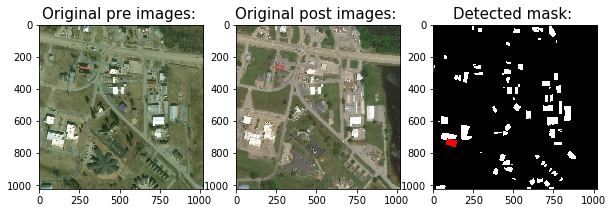

finish :  /home/molan/Desktop/xview2/test/images/images/test_pre_00100.png


In [0]:
# show a sample
image_ids = ['test_pre_00100.png']
for image_id in image_ids:
    # Load image and ground truth data
    # Run object detection
    detect_and_color_splash(model, image_path='/home/molan/Desktop/xview2/test/images/images/'+image_id)


##    3. Future work
In future work, we will perform attention model before image segmentation, which can find urban areas for priority segmentation reducing submaps without buildings. Like eyes moving on different objects when a person looks at the image, when a neural network recognizes an image, it focuses on some features at a time, and the recognition is more accurate. The result of the attention model is that at each recognition, the weight of each feature is first calculated, and then the weight summed. The larger the weight, the larger the feature's contribution to the current recognition.

![exp for attention model 2](https://drive.google.com/uc?id=1Lz3H3gIrlQ_DszpvD5nMuyLqDhgJsTF5)
